In [1]:
# Imports from the helpers folder, containing the lstm code and auxilliary functions
import sys  
sys.path.insert(0, "helpers/")
from lstm import Model, Optimization
from aux_functions import (dateindex_from_weeknum, dateindex_from_timestamp, ts_train_test_split, 
                           cols_with_most_corr, lagged_corr, lagged_corr_matrix, 
                           cols_with_most_lagged_corr, calculate_pvalues, corr_feature_selection)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
import statsmodels.api as sm
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency, kruskal
# Packages of forecasting models
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)
import pmdarima as pm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [2]:
# Daily sales data daily sales data
milan_data_df = pd.read_csv("../datasets/milan_daily.csv", index_col=[0], parse_dates=True)
print("Milan sales data:", milan_data_df.shape)
print(milan_data_df.head())
print("\n")

# Exogenous weather data
parser = lambda date: datetime.strptime(date, '%d/%m/%Y')
milan_weather_df = pd.read_csv("../datasets/Eso_data/weather/milano_weather_data.csv", index_col=[1], parse_dates=True, date_parser=parser)

Milan sales data: (1357, 1)
            qty
time           
2016-04-14  119
2016-04-15  119
2016-04-16  206
2016-04-17  211
2016-04-18   85




In [3]:
def augment_store_data (store_df, loc_weather_df):
    store_daily_totals = store_df

    # Check for NAN values in sales and replace them if they are present
    sales_nan_indices = store_daily_totals[store_daily_totals.isnull().any(axis=1)].index
    for nan_idx in sales_nan_indices:
        n_days_ago = nan_idx - timedelta(days=1)
        store_daily_totals.loc[nan_idx, "qty"] = np.mean(store_daily_totals.loc[n_days_ago:nan_idx,"qty"].values)
    
    ## WEATHER DATA
    
    # We won't be using the following cols (nan vals or categorical)
    loc_weather_df = loc_weather_df.drop(["LOCALITA", "PRESSIONEMEDIA mb", "PIOGGIA mm"], axis=1)
    loc_weather_df = loc_weather_df.loc[store_daily_totals.index[0]:,:]
    
    # Encode the weather phenomena
    # Nan (bello) = 2
    # Solo Pioggia = -1
    # Pioggia + extra = -2
    # Resto = 1
    loc_weather_df.FENOMENI.fillna(2, inplace=True)
    loc_weather_df.FENOMENI.replace(to_replace=loc_weather_df.FENOMENI[loc_weather_df.FENOMENI == "pioggia "], value=-1, inplace=True)
    pioggia_and_index = [True if (isinstance(fenomeno,str) and "pioggia" in fenomeno) else False for fenomeno in loc_weather_df.FENOMENI.values]
    loc_weather_df.FENOMENI.replace(to_replace=loc_weather_df.FENOMENI[pioggia_and_index], value=-2, inplace=True)
    the_others = [True if (isinstance(fenomeno,str)) else False for fenomeno in loc_weather_df.FENOMENI.values]
    loc_weather_df.FENOMENI.replace(to_replace=loc_weather_df.FENOMENI[the_others], value=1, inplace=True)

    # Now that the Fenomeni data is not NaN anymore, we also clear any actual NaN rows we might have
    # Check for NAN values in sales and replace them if they are present
    weather_nan_indices = loc_weather_df[loc_weather_df.isnull().any(axis=1)].index
    print(weather_nan_indices)
    for nan_idx in weather_nan_indices:
        for col in loc_weather_df.columns[:-1]:
            n_days_before = nan_idx - timedelta(days=1)
            loc_weather_df.loc[nan_idx, col] = np.mean(loc_weather_df.loc[n_days_before:nan_idx, col])
    
    # Here we add exogenous data we run the train the network with and without these new data. 
    # If the prediction improves then we are looking at leading indicator and better forecast accuracy.
    store_daily_weather_augmented = store_daily_totals.copy(deep=True)
    for w_col in loc_weather_df.columns:
        store_daily_weather_augmented[w_col] = loc_weather_df.loc[:, w_col]
   
    
    return store_daily_totals, store_daily_weather_augmented

# Augment single location sales data and then put everything together
daily_default, daily_augmented = augment_store_data(milan_data_df, milan_weather_df)
print("Milan data original shape:", daily_default.shape)
print("Milan + exogenous data shape:", daily_augmented.shape)
# Create copy of the augmented dataset to use for the models
milan_model_copy = daily_augmented.iloc[:, :-1].copy(deep=True)

DatetimeIndex(['2017-01-26', '2019-02-05'], dtype='datetime64[ns]', name='DATA', freq=None)
Milan data original shape: (1357, 1)
Milan + exogenous data shape: (1357, 12)


In [4]:
# Expand the exogenous dataset with aiditional signals that will help us with data analysis and exploration
daily_augmented["day_of_week"] = daily_augmented.index.dayofweek

# Calc rolling mean with window m
m=15
qty_roll_mean = daily_augmented.qty.rolling(window=m).mean()
mean_first_m = np.mean(daily_augmented.iloc[:15, 0])
full_roll_mean = qty_roll_mean.fillna(mean_first_m)

# Add signals for rolling mean and compatibility of phenomena
new_signal_vals = [1 if val > full_roll_mean[idx] else -1 for idx, val in enumerate(daily_augmented.qty.values)]
daily_augmented["rolling_meanlbl"] = new_signal_vals
daily_augmented["compatibility"] = daily_augmented.FENOMENI * daily_augmented.rolling_meanlbl

# Add trigonometric versions of the days of the year signal. This won't be used for analysis, just for charting
# and later for the LSTM models
day_yearly_nr = np.array(list(map(int, daily_augmented.index.strftime('%j').tolist())))
nrm_days = day_yearly_nr/365
daily_augmented["sin_day"] =  np.sin((day_yearly_nr/365) * 2*np.pi)
daily_augmented["cos_day"] = np.cos((day_yearly_nr/365) * 2*np.pi)
daily_augmented["sincos_day"] = np.sin((day_yearly_nr/365) * 2*np.pi) * np.cos((day_yearly_nr/365) * 2*np.pi)


# Calc annual means
daily_augmented["yearly_mean"] = np.zeros(daily_augmented.shape[0])
for i in range(2016, 2020):
    mean = daily_augmented.loc[str(i)].qty.mean()
    daily_augmented.loc[str(i), "yearly_mean"] = mean
    
# Add a singal of months and calculate monthly means
daily_augmented["month"] = daily_augmented.index.month
monthly_means = daily_augmented.qty.resample("M").mean()    
daily_augmented["monthly_mean"] = [monthly_means.loc[str(daily_idx.year)+"-"+str(daily_idx.month)].values[0] for daily_idx in daily_augmented.index]

# Yearly mean lbl
daily_augmented["ymean_lbl"] = [1 if val > daily_augmented["yearly_mean"][idx] else -1 for idx, val in enumerate(daily_augmented.monthly_mean.values)]

daily_augmented

,qty,TMEDIA °C,TMIN °C,TMAX °C,PUNTORUGIADA °C,UMIDITA %,VISIBILITA km,VENTOMEDIA km/h,VENTOMAX km/h,RAFFICA km/h,...,day_of_week,rolling_meanlbl,compatibility,sin_day,cos_day,sincos_day,yearly_mean,month,monthly_mean,ymean_lbl
time,,,,,,,,,,,,,,,,,,,,,
2016-04-14,119,17.0,11.0,24.0,8.0,58.0,10.0,10.0,19.0,0.0,...,3,-1,2,9.721182e-01,-0.234491,-2.279533e-01,136.931298,4,143.882353,1
2016-04-15,119,16.0,12.0,20.0,8.0,57.0,10.0,9.0,17.0,0.0,...,4,-1,-2,9.679378e-01,-0.251190,-2.431364e-01,136.931298,4,143.882353,1
2016-04-16,206,17.0,11.0,21.0,7.0,53.0,10.0,7.0,17.0,0.0,...,5,1,2,9.634705e-01,-0.267814,-2.580312e-01,136.931298,4,143.882353,1
2016-04-17,211,17.0,14.0,21.0,11.0,65.0,10.0,9.0,19.0,0.0,...,6,1,2,9.587178e-01,-0.284359,-2.726202e-01,136.931298,4,143.882353,1
2016-04-18,85,17.0,13.0,23.0,8.0,57.0,10.0,9.0,24.0,33.0,...,0,-1,1,9.536810e-01,-0.300820,-2.868861e-01,136.931298,4,143.882353,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,194,3.0,0.0,10.0,2.0,85.0,17.0,4.0,9.0,0.0,...,4,-1,-1,-6.880243e-02,0.997630,-6.863939e-02,197.879452,12,206.032258,1
2019-12-28,228,3.0,0.0,9.0,2.0,87.0,16.0,3.0,8.0,0.0,...,5,1,1,-5.161967e-02,0.998667,-5.155085e-02,197.879452,12,206.032258,1
2019-12-29,233,2.0,0.0,6.0,3.0,97.0,1.0,4.0,9.0,0.0,...,6,1,1,-3.442161e-02,0.999407,-3.440121e-02,197.879452,12,206.032258,1


# Scenario 1:  Sales and day of the week

This scenario explores how the day of the week is connected to the amount of sold produts. If we were to take a sample of the data we could actually see the sales quantity is mostly higher on Fridays (day 5) or the weekend. Of course this does not hold when we have seasonal sales, but that will be explored later.

In [5]:
daily_augmented.iloc[180:190, [0,12]]

,qty,day_of_week
time,,
2016-10-11,43,1
2016-10-12,65,2
2016-10-13,50,3
2016-10-14,96,4
2016-10-15,219,5
2016-10-16,208,6
2016-10-17,48,0
2016-10-18,78,1
2016-10-19,90,2


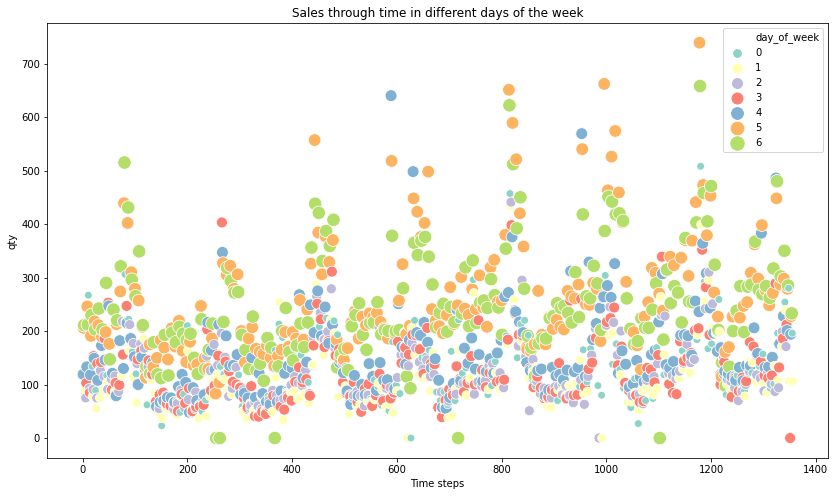

In [6]:
plt.figure(figsize=(14,8))
plt.title("Sales through time in different days of the week")
ax = sns.scatterplot(x=range(0, len(daily_augmented)), y="qty", hue="day_of_week", palette="Set3",\
                     size="day_of_week", sizes=(60, 180), legend="full", data=daily_augmented)
ax.set(xlabel="Time steps")
plt.show()

In [7]:
dow_ctg_matrix = pd.crosstab(daily_augmented["rolling_meanlbl"], daily_augmented["day_of_week"])
print(dow_ctg_matrix, "\n")
chi2_contingency(dow_ctg_matrix)

day_of_week        0    1    2    3    4    5    6
rolling_meanlbl                                   
-1               168  176  171  166  134   12   20
 1                26   18   22   28   60  182  174 



(705.0496952021987,
 4.968408770452895e-149,
 6,
 array([[121.08916728, 121.08916728, 120.46499632, 121.08916728,
         121.08916728, 121.08916728, 121.08916728],
        [ 72.91083272,  72.91083272,  72.53500368,  72.91083272,
          72.91083272,  72.91083272,  72.91083272]]))

# Scenario 2: Sales and seasonal sales

Most people go shopping and buy more things when there are longer periods of sales for certain holidays, like the Christmas and New Year period or also the two last summer months of July and August. This is something that can be seen by looking at the sales data we have and also an event that will probably keep happening every year. So basically we are trying to check if we can find some data which could show us that in certain parts of the year, people buy more.

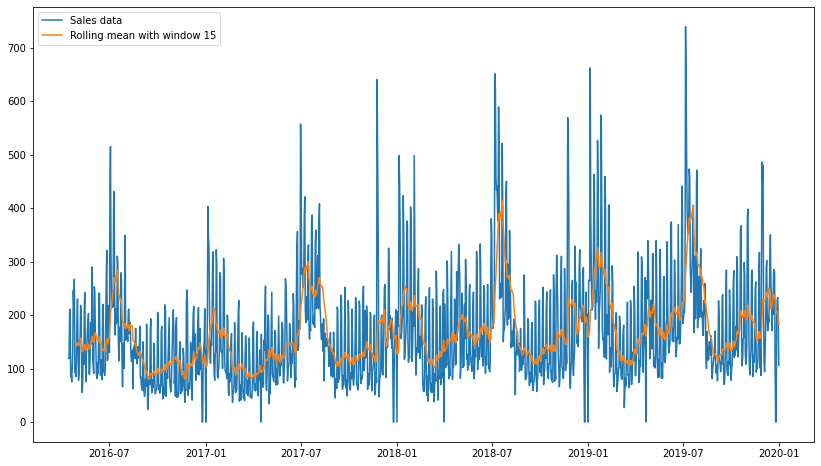

In [8]:
plt.figure(figsize=(14,8))
plt.plot(daily_augmented.qty, label="Sales data")
plt.plot(qty_roll_mean, label="Rolling mean with window "+str(m)) 
plt.legend()
plt.show()

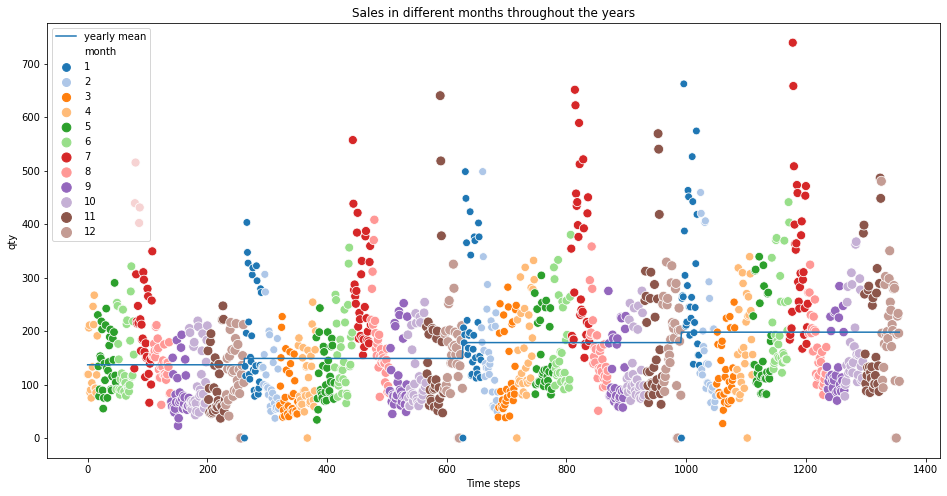

In [9]:
plt.figure(figsize=(16,8))
plt.title("Sales in different months throughout the years")
plt.plot(range(0, len(daily_augmented)), daily_augmented.yearly_mean.values, label="yearly mean")
ax = sns.scatterplot(x=range(0, len(daily_augmented)), y="qty", hue="month", palette="tab20", size="month", sizes=(60, 100),\
                     legend="full", data=daily_augmented)
ax.set(xlabel="Time steps")
plt.show()

In [10]:
# Build a contingency table for the sales by months and the annual mean
sc2_ctg_matrix = pd.crosstab(daily_augmented["ymean_lbl"], daily_augmented["month"])
sc2_ctg_matrix
print(sc2_ctg_matrix)
chi2_contingency(sc2_ctg_matrix)

month      1   2   3   4   5   6    7   8    9    10  11  12
ymean_lbl                                                   
-1          0  84  93  90  93  30    0  62  120  124  30  31
 1         93   0   0  17  31  90  124  62    0    0  90  93


(802.3797837524744,
 5.841823188989593e-165,
 11,
 array([[51.87988209, 46.85924834, 51.87988209, 59.68975682, 69.17317612,
         66.94178335, 69.17317612, 69.17317612, 66.94178335, 69.17317612,
         66.94178335, 69.17317612],
        [41.12011791, 37.14075166, 41.12011791, 47.31024318, 54.82682388,
         53.05821665, 54.82682388, 54.82682388, 53.05821665, 54.82682388,
         53.05821665, 54.82682388]]))

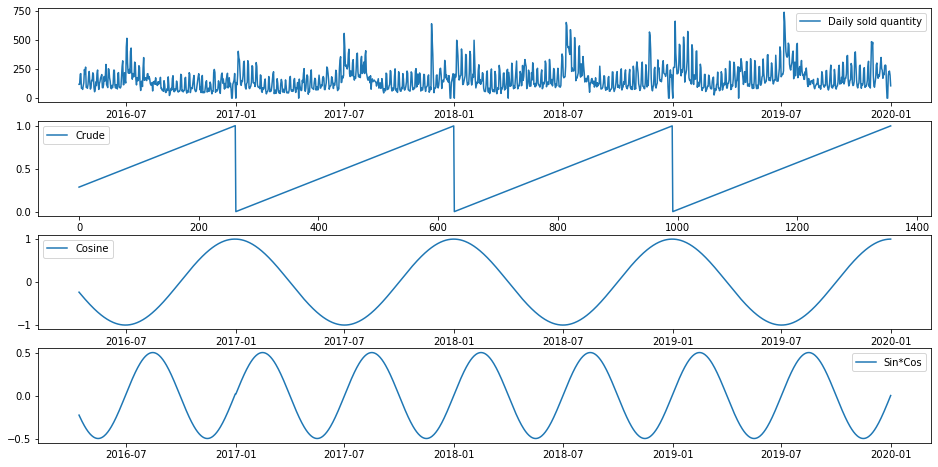

In [11]:
plt.figure(figsize=(16,8))
plt.subplot(4, 1, 1)
plt.plot(daily_augmented.qty, label="Daily sold quantity")
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(nrm_days, label="Crude")
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(daily_augmented.cos_day, label="Cosine")
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(daily_augmented.sincos_day, label="Sin*Cos")
plt.legend()
plt.show()

# Scenario 3: Sales and weather (exogenous variables)

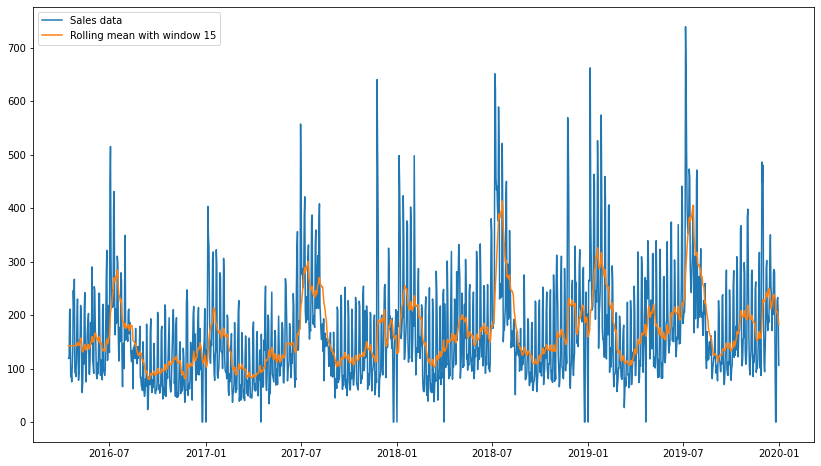

In [12]:
plt.figure(figsize=(14,8))
plt.plot(daily_augmented.qty, label="Sales data")
plt.plot(full_roll_mean, label="Rolling mean with window "+str(m)) 
plt.legend()
plt.show()

In [13]:
# Chi-sq and contingency table for the weather phenomena and the mean amount of bought products
weather_ctg_matrix = pd.crosstab(daily_augmented["rolling_meanlbl"], daily_augmented["FENOMENI"])
print(weather_ctg_matrix, "\n")
chi2_contingency(weather_ctg_matrix)

FENOMENI          -2   -1    1    2
rolling_meanlbl                    
-1               164  143  133  407
 1                82  105   86  237 



(4.718207066890425,
 0.1936331605143166,
 3,
 array([[153.54605748, 154.79439941, 136.69344141, 401.96610169],
        [ 92.45394252,  93.20560059,  82.30655859, 242.03389831]]))

In [14]:
# Bin the data into an equal number of bins, based on their quartiles
exo_var = "TMIN °C"
qcut_res = pd.qcut(daily_augmented[exo_var], q=4, retbins=True)
qcut_bins = qcut_res[1]
print("Temp bin vals:", qcut_bins, "\n")
binned_vals = []
for val in daily_augmented[exo_var].values:
    if (val >= qcut_bins[0] and val <= qcut_bins[1]):
        binned_vals.append(1)
    elif (val > qcut_bins[1] and val <= qcut_bins[2]):
        binned_vals.append(2)
    elif (val > qcut_bins[2] and val <= qcut_bins[3]):
        binned_vals.append(3)
    else:
        binned_vals.append(4)

daily_augmented["temp_binned"] = binned_vals
contig_matrix = pd.crosstab(daily_augmented["rolling_meanlbl"], daily_augmented["temp_binned"])
print(contig_matrix, "\n")

Temp bin vals: [-6.  4. 11. 18. 26.] 

temp_binned        1    2    3    4
rolling_meanlbl                    
-1               208  217  245  177
 1               132  143  133  102 



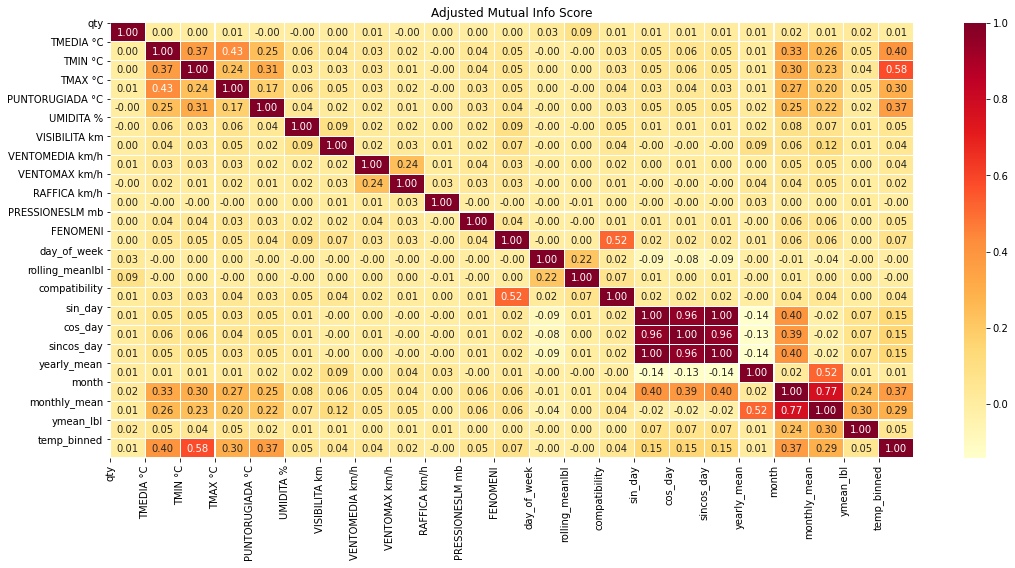

In [15]:
from sklearn.metrics import adjusted_mutual_info_score

mis_matrix = np.zeros(shape=(len(daily_augmented.columns), len(daily_augmented.columns)))
for i in range(0,mis_matrix.shape[0]):
    for j in range(0, mis_matrix.shape[1]):
        mis_matrix[i][j] = adjusted_mutual_info_score(daily_augmented.iloc[:,i].values, daily_augmented.iloc[:,j].values)
        
plt.figure(figsize=(18,8))        
sns.heatmap(data=mis_matrix, cmap="YlOrRd", annot=True, fmt=".2f", linewidths=.1)
plt.xticks(ticks=np.arange(mis_matrix.shape[0]), labels=daily_augmented.columns.values, rotation=90)
plt.yticks(np.arange(mis_matrix.shape[1]), labels=daily_augmented.columns.values, rotation=360)
plt.title("Adjusted Mutual Info Score")
plt.show()